<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import skimage
from skimage import data
from skimage import io
from skimage import feature
import os
import seaborn as sns
import cv2

#### Below are useful util functions

In [2]:
def load_data(df, img_w, img_h, picture='Pictures'):
    '''
    load the image from df[picture] series
    return: image list
    '''
    print('Reading training images')
    img_list = []
    for index, data in df.iterrows():
        img = data[picture]
        #resize each image to the standard img_w * img_h 
        img = cv2.resize(img, (img_w, img_h), cv2.INTER_LINEAR)
        img_list.append(img)
    img_list = np.array(img_list, dtype=np.uint8)
    img_list = img_list.astype('float32')
    img_list = img_list / 255
    return img_list

def load_label(df):
    '''
    load the label from df[Encoding] series
    return: label list 
    '''
    print('Reading training labels')
    label_list = []
    for index, data in df.iterrows():
        label = data['Encoding']
        label_list.append(label)
    label_list = np.array( label_list, dtype=np.int32 )
    label_list = label_list.astype('long')
    return label_list

def svd_images(df, img_w, img_h, picture='Pictures'):
    '''
    Get the SVD decomposition of the matrix made by all the flattened images
    '''
    resized_pictures = load_data(df, img_w, img_h, picture)
    if picture == 'Pictures':
        resized_pictures = resized_pictures.reshape(-1, img_w*img_h*3)
    elif picture == 'canny':
        resized_pictures = resized_pictures.reshape(-1, img_w*img_h)

    resized_pictures = resized_pictures / resized_pictures.shape[0]
    mean_pictures = np.mean(resized_pictures,axis=0)
    resized_pictures = resized_pictures - mean_pictures
    u, s, vh = np.linalg.svd(resized_pictures) 
    return u, s, vh, mean_pictures

def feature_canny(image):
    """
    return edge detection through canny algorithm
    """
    image = cv2.resize(image, (128, 128), cv2.INTER_LINEAR) / 255
    gray = skimage.color.rgb2gray(image)
    gray = np.array(gray * 255, dtype=np.uint8)
    canny = cv2.Canny(gray, 100, 200)/255
    canny = np.array(canny).flatten()
    return canny

In [3]:
data = pd.read_hdf("training_data.h5", "data")
test_data = pd.read_hdf("test_data.h5", "data")

print(len(data))
data.head()

# get the eigenvectors of the matrix made by all the images
u, s, vt, mean_pictures = svd_images(data, 32, 32, picture='Pictures')
# get the eigenvectors of the matrix made by the canny images
data['canny'] = data['Pictures'].apply(feature_canny)
test_data['canny'] = test_data['Pictures'].apply(feature_canny)
u_canny, s_canny, vt_canny, mean_canny = svd_images(data, 64, 64, picture='canny')

1501
Reading training images
Reading training images


#### Display three of the learning set images.

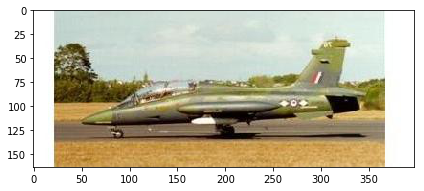

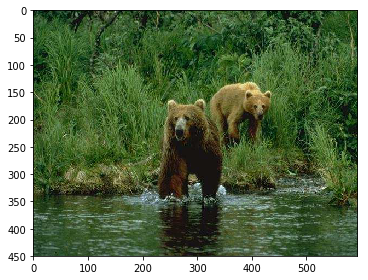

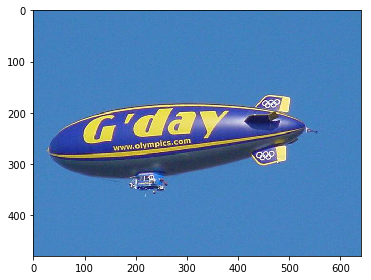

In [4]:
subsample = data.groupby('Encoding').agg(lambda x: x.iloc[0])
for i in range(3):
    skimage.io.imshow(subsample.iloc[i]['Pictures'])
    plt.show()

#### Provide graphical summaries of the sizes of the images, pixel intensities, and class frequencies.

In [5]:
category = ["Airplanes", "Bear", "Blimp", "Comet", "Crab", "Dog", "Dolphin", "Giraffe", 
            "Goat", "Gorilla", "Kangaroo", "Killer-Whale", "Leopards", "Llama", 
            "Penguin", "Porcupine", "Teddy-Bear", "Triceratops", "Unicorn", "Zebra"]

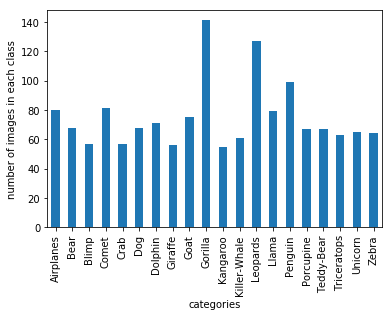

In [6]:
# class frequencies summary
class_frequency = data.groupby('Encoding').size()
class_frequency.plot.bar()
plt.ylabel("number of images in each class")
plt.xlabel("categories")
plt.xticks(range(len(category)), category, rotation='vertical')
plt.show()


We show the summaries of the class frequencies in the figure above, and will show the statistics of the sizes of the images and pixel intensities at bottom.

#### sizes of the images summary

In [7]:
def feature_size(image):
    """
    return image size (over 1000000 to normalize the values)
    """
    return image.size / 1000000


#### pixel intensity

In [8]:
def feature_avg_red(image):
    """
    return the normalized average of the red-channel pictures for the image
    """
    return image[:,:,0].mean()/255

def feature_avg_green(image):
    """
    return the normalized average of the green-channel pictures for the image
    """
    return image[:,:,1].mean()/255

def feature_avg_blue(image):
    """
    return the normalized average of the blue-channel pictures for the image
    """
    return image[:,:,2].mean()/255
    
def feature_std_red(image):
    """
    return standard derivation of red channel
    """
    return image[:, :, 0].std()/255

def feature_std_green(image):
    """
    return standard derivation of green channel
    """
    return image[:, :, 1].std()/255

def feature_std_blue(image):
    """
    return standard derivation of blue channel
    """
    return image[:, :, 2].std()/255

def feature_avg_gray(image):
    """
    return mean value of grayscale
    """
    return np.mean(image[:, :, 0] + image[:, :, 1] + image[:, :, 2] / 3)/255

def feature_std_gray(image):
    """
    return mean value of grayscale
    """
    return np.std(image[:, :, 0] + image[:, :, 1] + image[:, :, 2] / 3)/255


#### Provide functions that summarize pixel intensity data (e.g.,https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d). Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspect ratio.

#### Aspect ratio

In [9]:
def feature_aspect_ratio(image):
    """
    return aspect ratio of the image, 
    i.e., the height divided by the width of the image
    """
    return image.shape[0] / image.shape[1]


####  The feature of amount of corners detected by Harris corner detector

In [10]:

def short_side_resize(image, length=256):
    """
    resize the image to a fixed short side length
    """
    height, width, _ = image.shape
    if height < width:
        ratio = length / height
    else:
        ratio = length / width
    new_height = int(height * ratio)
    new_width = int(width * ratio)
    return skimage.transform.resize(image, (new_height, new_width), mode='reflect', anti_aliasing=True)

def center_crop(image, length=224):
    """
    crop the center patch of the image with length * length
    """
    height, width, _ = image.shape
    cx, cy = height // 2, width // 2
    lx, ly = cx - length//2, cy - length//2
    hx, hy = length + lx, length + ly
    return image[lx:hx, ly:hy, :]

def feature_harris(image):
    """
    return amount of corners detected by Harris corner detector
    """
    image = center_crop(short_side_resize(image))
    gray = skimage.color.rgb2gray(image)
    gray = np.array(gray * 255, dtype=np.uint8)
    harris = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    harris_corners = np.where(harris > 0)
    return len(harris_corners[0]) / harris.size


####  Test the feature of differences of images processed by two Gaussian filters with different variance

In [11]:
def feature_dog(image):
    """
    return the differences of images processed by two Gaussian 
    filters with different variance (we choose 0.3 and 0.5)
    """
    gray = skimage.color.rgb2gray(image)
    g3 = np.asarray(skimage.filters.gaussian(gray, sigma=0.3))
    g5 = np.asarray(skimage.filters.gaussian(gray, sigma=0.5))
    dog = g3-g5
    return sum(sum(dog > 0.05 *dog.max() ))/dog.size

####  Test the feature of luminance, blue chroma and red chroma components

In [12]:
def feature_avg_y(image):
    """
    return mean value of luminance Y
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 0].mean()/255


def feature_avg_cb(image):
    """
    return mean value of blue chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 1].mean()/255

def feature_avg_cr(image):
    """
    return mean value of red chroma component (Cr)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 2].mean()/255

def feature_std_y(image):
    """
    return standard derivation of luminance (Y)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 0].std()/255

def feature_std_cb(image):
    """
    return standard derivation of blue chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 1].std()/255

def feature_std_cr(image):
    """
    return standard derivation of red chroma component (Cr)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 2].std()/255


####  Test the feature of Histogram of Oriented Gradients (HOG)

In [13]:

def feature_avg_hog(image):
    """
    return mean value of Histogram of Oriented Gradients (HOG)
    """
    return skimage.feature.hog(image).mean()

def feature_std_hog(image):
    """
    return standard derivation of Histogram of Oriented Gradients (HOG)
    """
    return skimage.feature.hog(image).std()


#### The feature of dot products with leading singular vectors

In [14]:
def feature_svd(image, mean_pictures, vt):
    """
    return dot products with leading singular vectors
    """
    resized_image = cv2.resize(image, (32, 32), cv2.INTER_LINEAR) / 255
    normalized_image = resized_image.reshape(32*32*3) - mean_pictures
    eigenvalues = vt[:5,:]@normalized_image / np.linalg.norm(normalized_image)
    return eigenvalues

def feature_canny_svd(image, mean_canny, vt_canny):
    """
    return dot products of canny edge image with leading singular vectors of edge images
    """
    resized_image = cv2.resize(image, (64, 64), cv2.INTER_LINEAR) / 255
    normalized_image = resized_image.reshape(64*64) - mean_canny
    eigenvalues = vt_canny[:2,:]@normalized_image 
    return eigenvalues

<h4> DataFrame Creation </h4>

In [15]:
def feature_frame(df):
    '''
    add all features to a DataFrame
    '''
    df["size"] = df["Pictures"].apply(feature_size)
    df["avg_red"] = df["Pictures"].apply(feature_avg_red)
    df["avg_green"] = df["Pictures"].apply(feature_avg_green)
    df["avg_blue"] = df["Pictures"].apply(feature_avg_blue)
    df['avg_gray'] = df['Pictures'].apply(feature_avg_gray) 
    df['std_red'] = df['Pictures'].apply(feature_std_red) 
    df['std_green'] = df['Pictures'].apply(feature_std_green) 
    df['std_blue'] = df['Pictures'].apply(feature_std_blue) 
    df['std_grey'] = df['Pictures'].apply(feature_std_gray) 
    df["aspect_ratio"] = df["Pictures"].apply(feature_aspect_ratio)
    df["harris"] = df["Pictures"].apply(feature_harris)
    df["dog"] = df["Pictures"].apply(feature_dog)
    df["avg_y"] = df["Pictures"].apply(feature_avg_y)
    df["avg_cb"] = df["Pictures"].apply(feature_avg_cb)
    df["avg_cr"] = df["Pictures"].apply(feature_avg_cr)
    df["std_y"] = df["Pictures"].apply(feature_std_y)
    df["std_cb"] = df["Pictures"].apply(feature_std_cb)
    df["std_cr"] = df["Pictures"].apply(feature_std_cr)
    df["avg_hog"] = df["Pictures"].apply(feature_avg_hog)
    df["std_hog"] = df["Pictures"].apply(feature_std_hog)
    df['svd'] = df['Pictures'].apply(feature_svd, mean_pictures=mean_pictures, vt=vt)     
    df['canny_svd'] = df['canny'].apply(feature_canny_svd, mean_canny=mean_canny, vt_canny=vt_canny) 
    del df['canny']
    return df

feature = feature_frame(data)
feature.head()


,Pictures,Encoding,size,avg_red,avg_green,avg_blue,avg_gray,std_red,std_green,std_blue,...,avg_y,avg_cb,avg_cr,std_y,std_cb,std_cr,avg_hog,std_hog,svd,canny_svd
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.0,0.195816,0.719042,0.693139,0.584908,0.794578,0.221203,0.251137,0.312346,...,0.654084,0.450585,0.521069,0.209788,0.057982,0.042520,0.069350,0.086811,"[-0.9411725618842666, 0.008966214811940402, -0...","[-4.131265285862971e-06, -2.5885726321449823e-07]"
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.0,0.221352,0.826431,0.742275,0.646295,0.920591,0.216836,0.292104,0.276149,...,0.712441,0.447331,0.545779,0.222930,0.024625,0.069641,0.074722,0.082233,"[-0.9452094848143205, -0.1284002312458272, -0....","[-4.131265285862971e-06, -2.5885726321449823e-07]"
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.0,0.194535,0.667152,0.579563,0.438250,0.696626,0.252515,0.267002,0.352605,...,0.569144,0.426911,0.550525,0.219960,0.101463,0.074436,0.068713,0.085799,"[-0.9194251189689553, -0.04598015488281377, 0....","[-4.131265285862971e-06, -2.5885726321449823e-07]"
3,"[[[174, 190, 187], [173, 189, 186], [172, 188,...",0.0,0.200430,0.596705,0.520189,0.305558,0.672473,0.253041,0.246156,0.327109,...,0.508131,0.396350,0.550898,0.210079,0.088122,0.061079,0.074841,0.080767,"[-0.8658767978779213, 0.005307098609816353, 0....","[0.017231397222499324, -0.012404929949506977]"
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.0,0.208560,0.578031,0.590215,0.338247,0.624215,0.289629,0.279945,0.370162,...,0.541838,0.393098,0.514607,0.243142,0.105869,0.027735,0.069497,0.086694,"[-0.887418659157311, 0.015802314068069624, 0.1...","[-4.131265285862971e-06, -2.5885726321449823e-07]"


In [16]:
feature.to_hdf("feature.h5", "data", mode="w")


/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:2378: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Pictures', 'svd', 'canny_svd']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


#### Examine how these image features vary between classes.

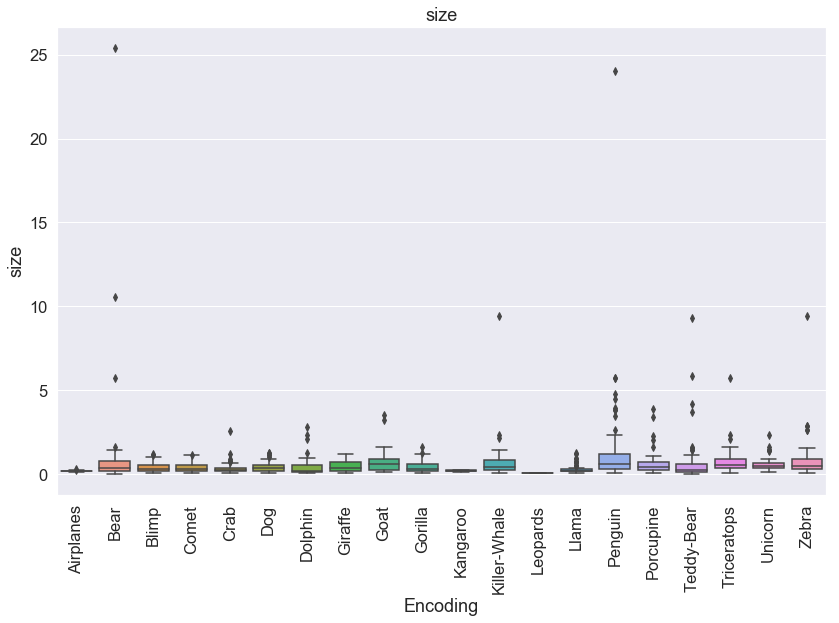

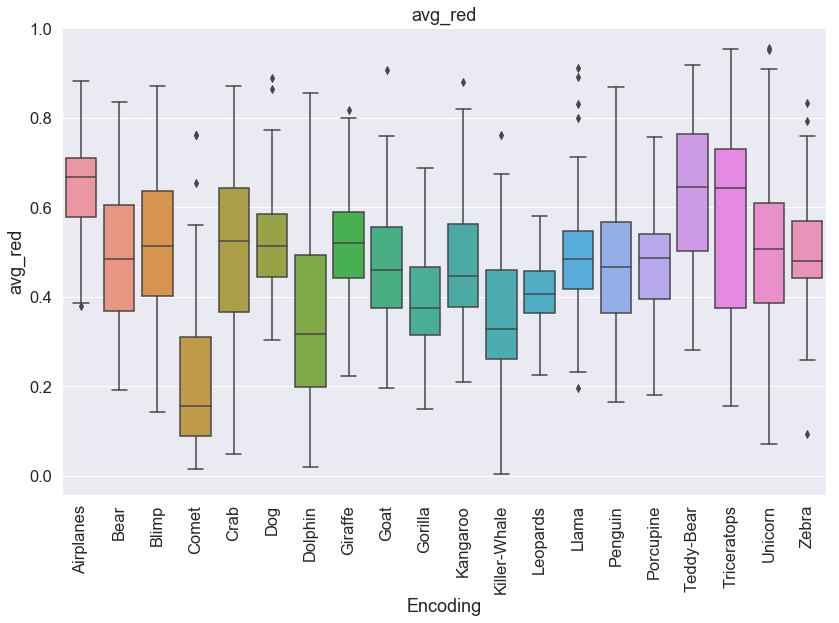

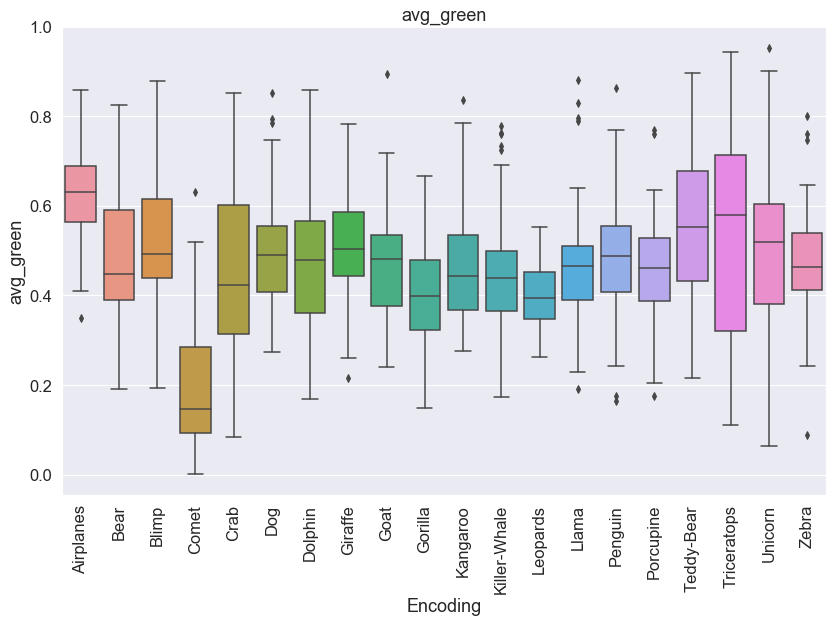

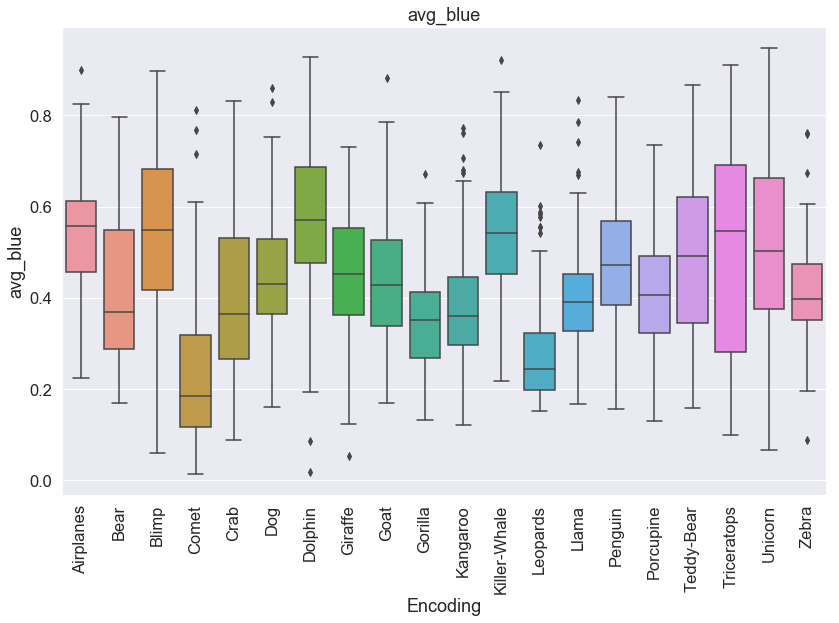

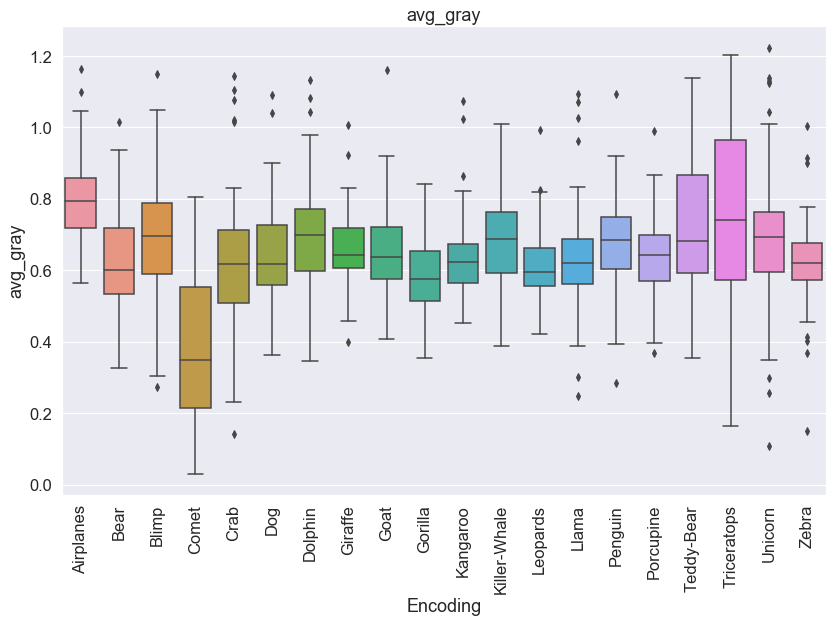

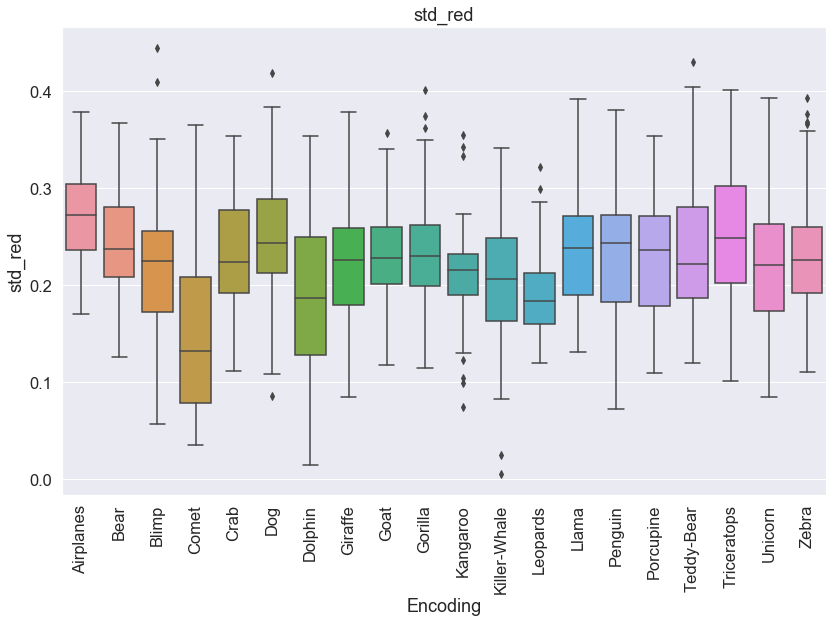

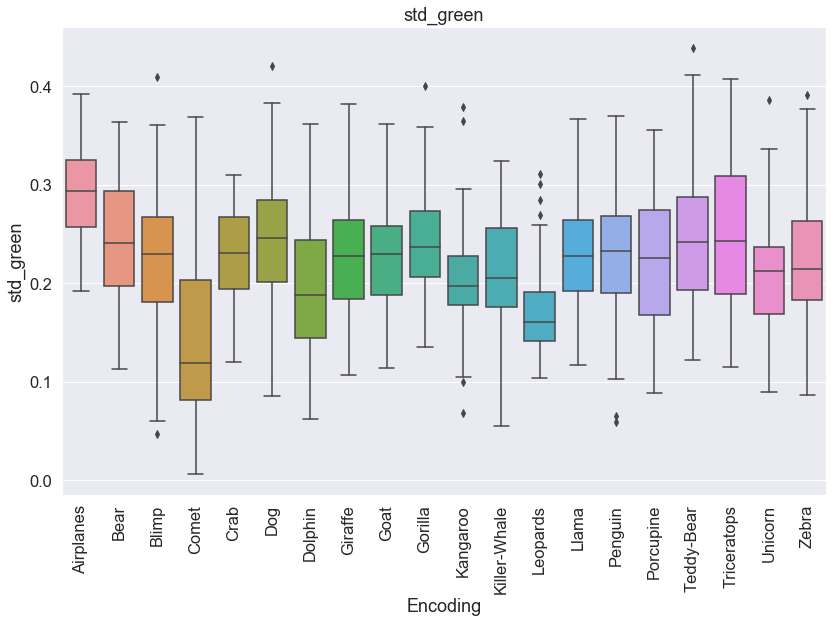

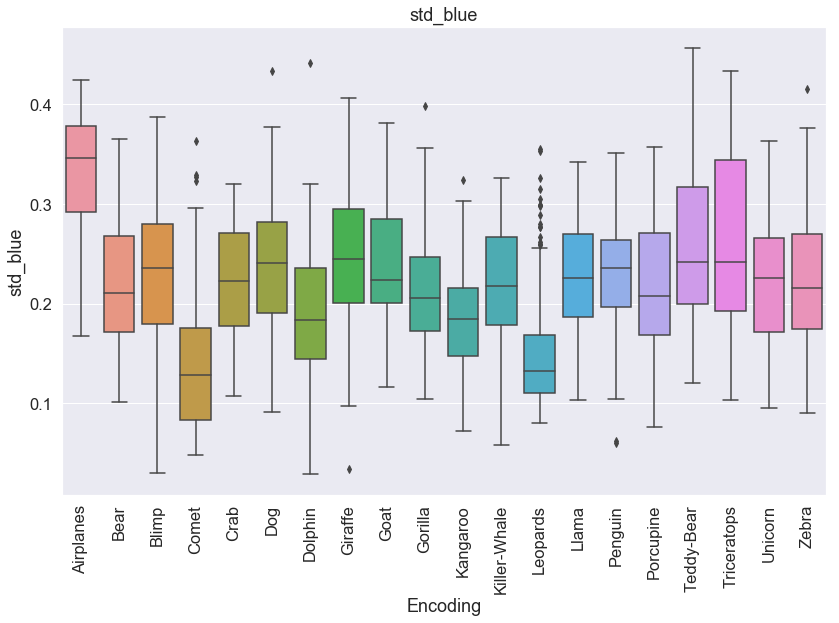

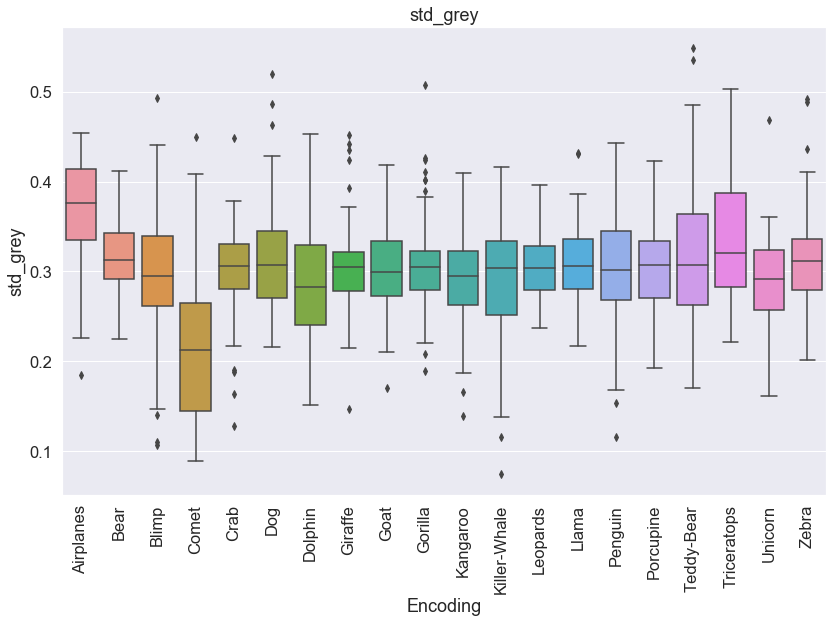

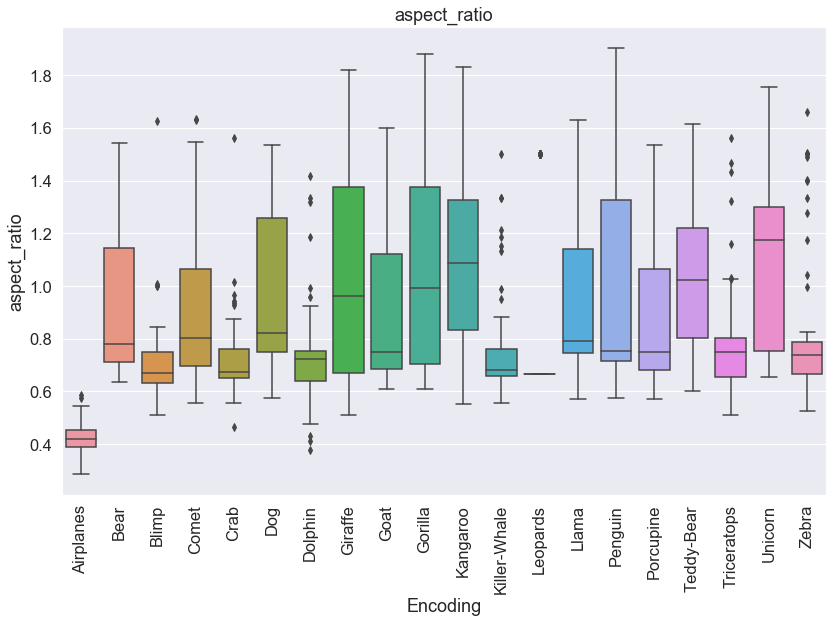

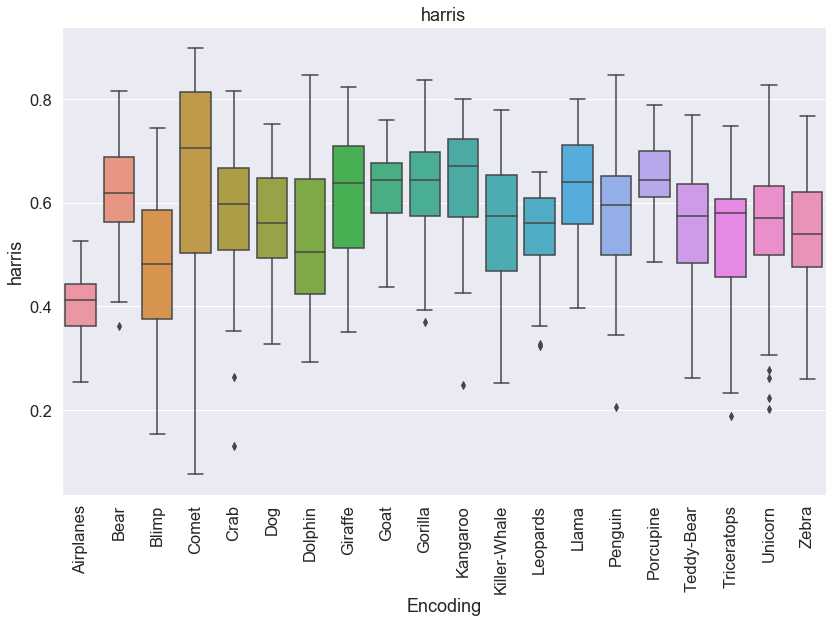

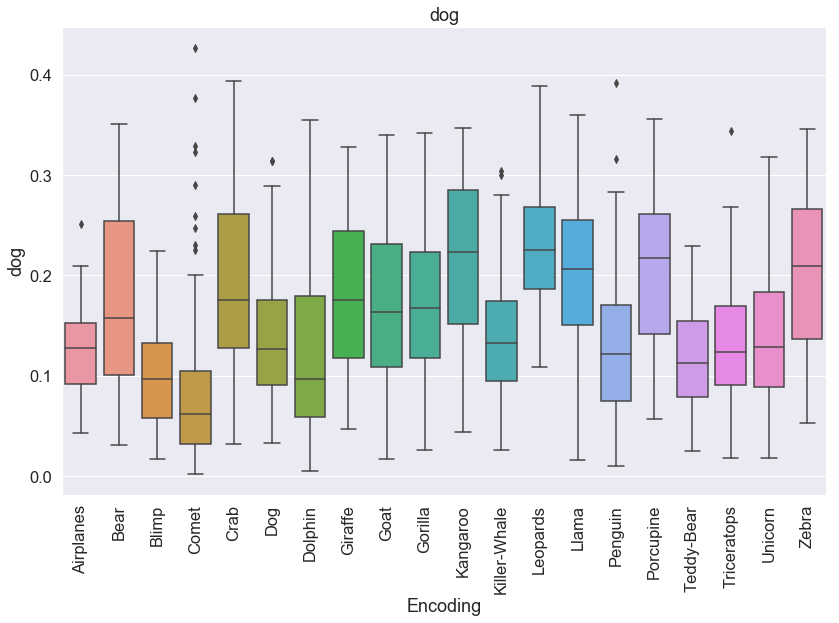

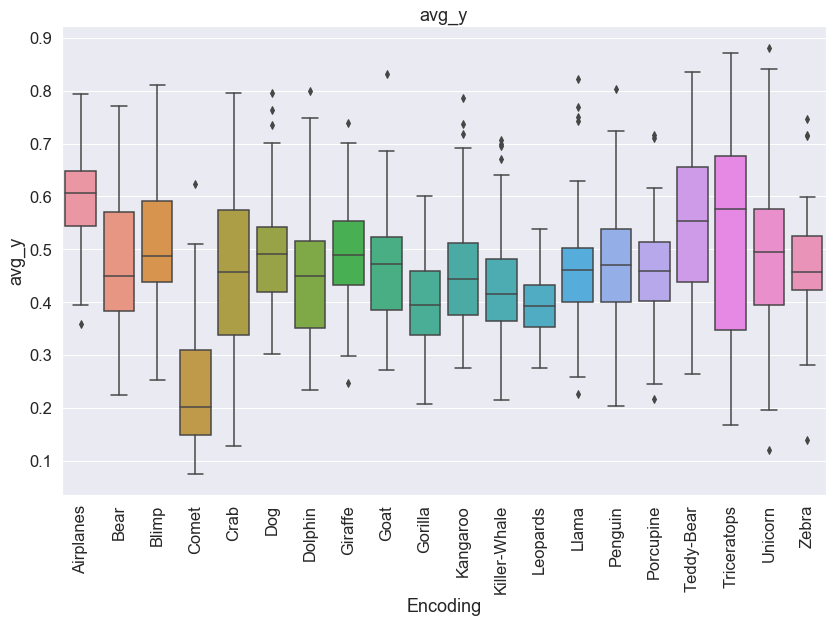

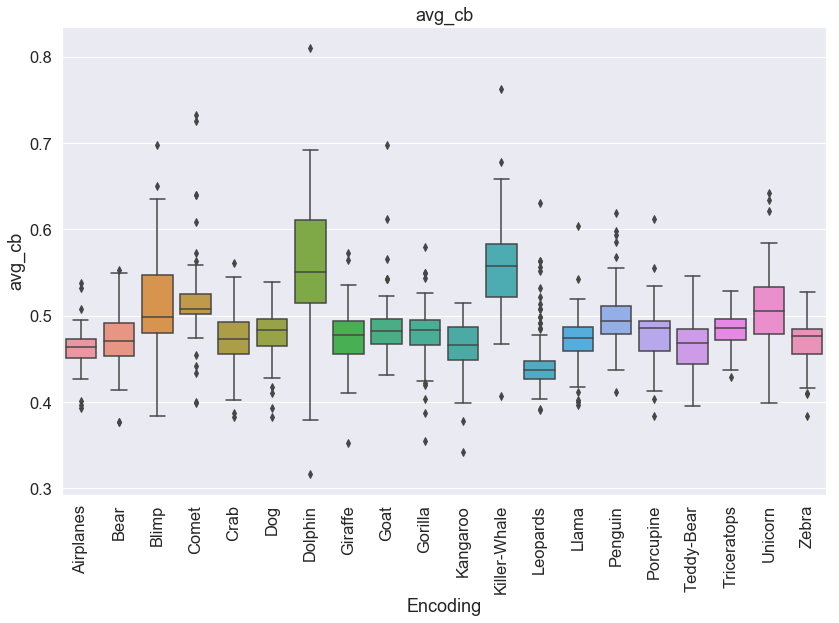

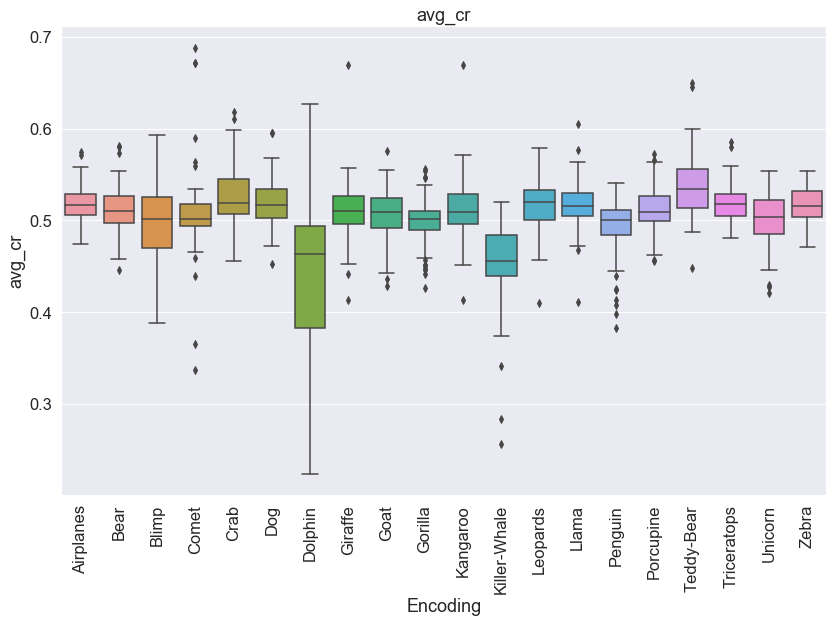

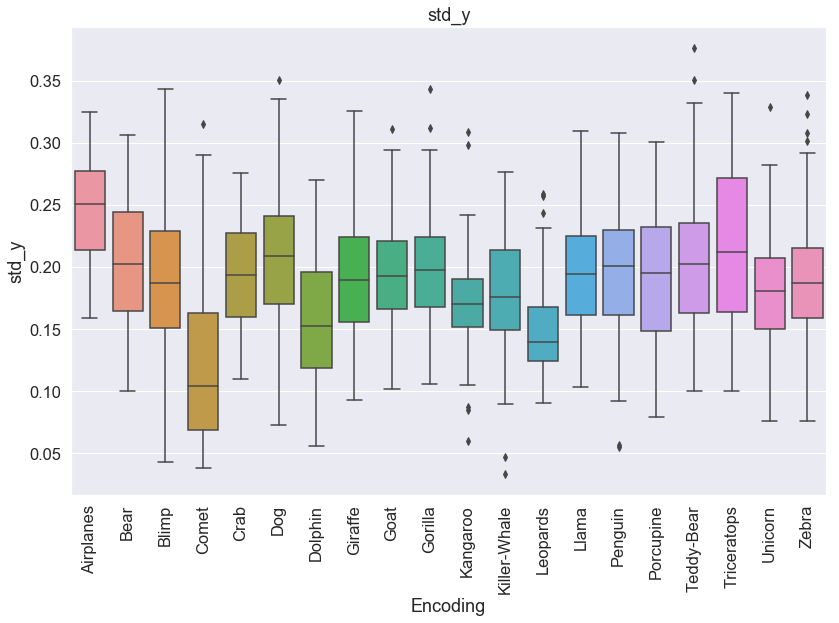

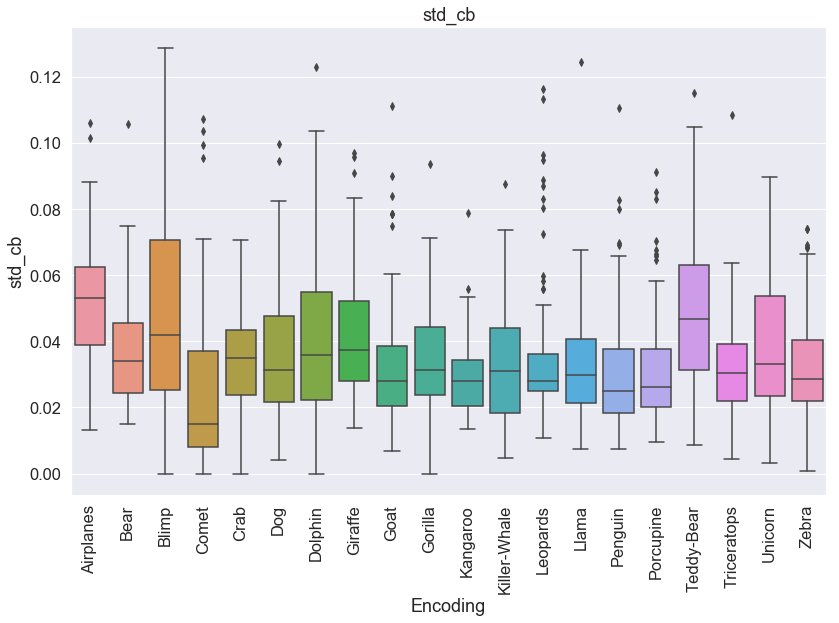

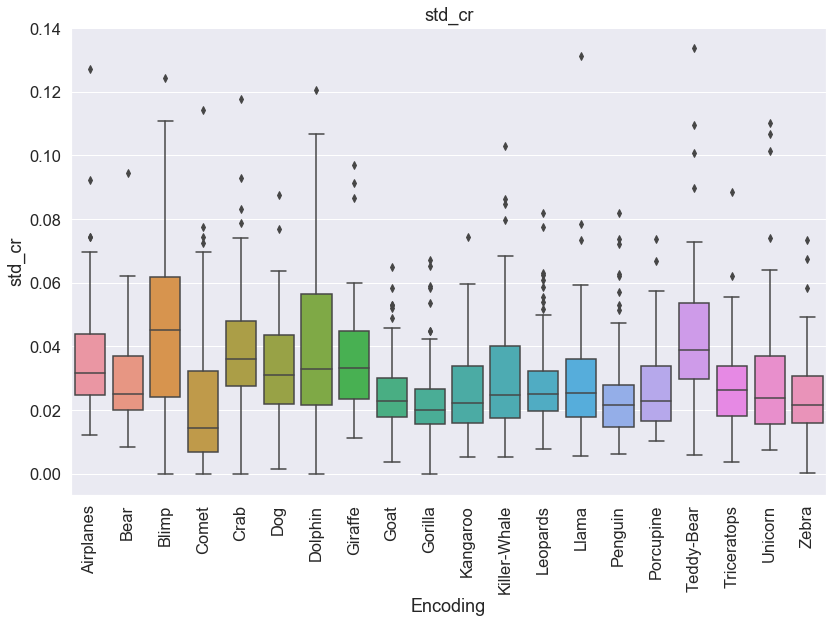

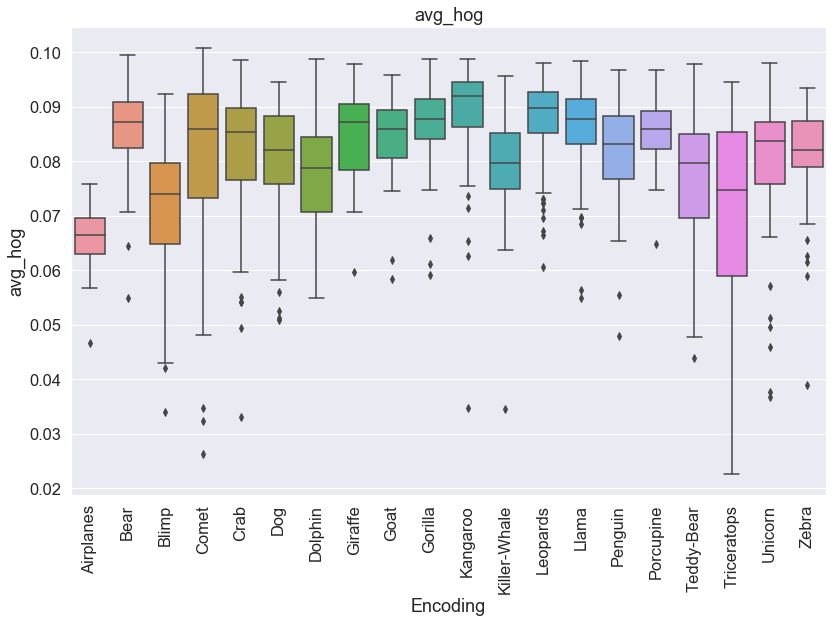

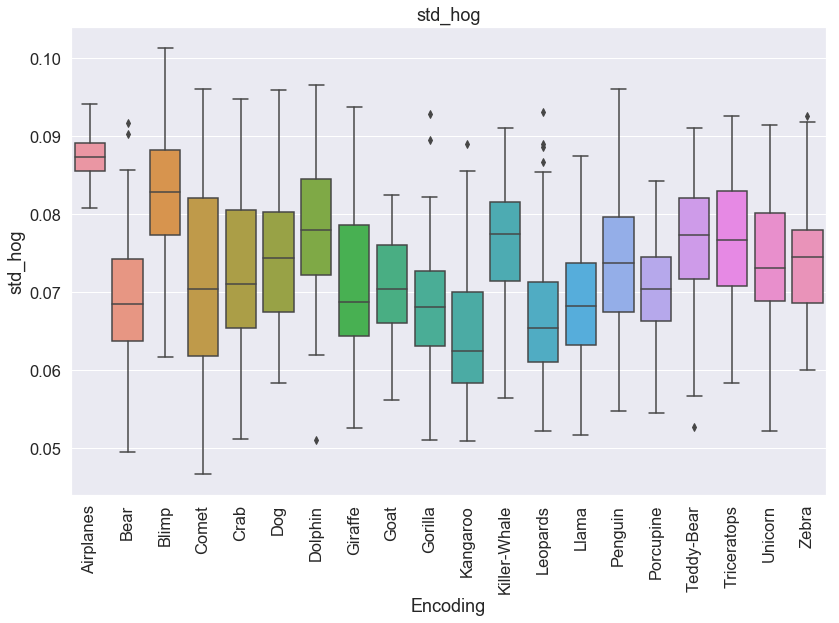

In [17]:
unplot = ['Encoding', 'svd', 'canny_svd', 'Pictures']
sns.set(font_scale=1.5)
try:
    os.stat("NB2_graph")
except:
    os.mkdir("NB2_graph")  

for column in feature.columns:
    if column not in unplot:
        plt.figure(figsize=(12, 9))
        sns.boxplot(x="Encoding", y=column, data=feature)
        plt.title(column)
        plt.xticks(range(len(category)), category, rotation='vertical')
        plt.tight_layout()
        plt.savefig("NB2_graph/"+column+".pdf")

#### get the features for testset

In [18]:
test_feature = feature_frame(test_data)
test_feature.head()

,Pictures,size,avg_red,avg_green,avg_blue,avg_gray,std_red,std_green,std_blue,std_grey,...,avg_y,avg_cb,avg_cr,std_y,std_cb,std_cr,avg_hog,std_hog,svd,canny_svd
0,"[[[80, 79, 74], [56, 55, 50], [54, 53, 48], [4...",1.620000,0.415610,0.419237,0.414082,0.604786,0.263549,0.256145,0.247505,0.294132,...,0.421360,0.500234,0.500736,0.220119,0.029094,0.014192,0.089145,0.066324,"[-0.8093690052065747, -0.16113474329732075, -0...","[0.048772324338107985, 0.007255451716494181]"
1,"[[[10, 15, 19], [10, 15, 19], [11, 16, 19], [1...",0.091821,0.567814,0.578798,0.525421,0.727508,0.313096,0.303087,0.301164,0.369454,...,0.551784,0.480145,0.500949,0.262229,0.017759,0.014203,0.083612,0.073176,"[-0.8173885005402451, -0.1492444392686673, -0....","[0.0797448227596835, 0.011501570834114138]"
2,"[[[232, 231, 247], [250, 249, 255], [235, 234,...",0.312006,0.524069,0.485613,0.465038,0.666615,0.269890,0.285496,0.322599,0.366499,...,0.487662,0.487224,0.520321,0.244063,0.031329,0.018378,0.073057,0.083716,"[-0.8895012787735834, 0.06455309233015812, -0....","[0.027395774374250375, 0.028131062332187057]"
3,"[[[97, 75, 77], [98, 76, 78], [99, 77, 79], [1...",0.070308,0.379204,0.327932,0.335599,0.509764,0.242566,0.205625,0.190042,0.355433,...,0.358297,0.497728,0.523933,0.184243,0.016433,0.019968,0.077639,0.079485,"[-0.8072447403287052, -0.10592963845612886, -0...","[0.002022648947340876, 0.0029655771067152756]"
4,"[[[19, 46, 55], [19, 46, 53], [20, 47, 54], [2...",0.244650,0.091162,0.159210,0.183873,0.289097,0.101250,0.113173,0.133987,0.179388,...,0.184419,0.522880,0.470311,0.095521,0.014645,0.013387,0.089243,0.066192,"[-0.6404077654686087, -0.38677998443864714, -0...","[0.003453400593607136, -0.0010129309029148165]"


In [19]:
test_feature.to_hdf("test_feature.h5", "data", mode="w")

### Reference

1. Christopher G. Harris and Mike Stephens. A combined corner and edge detector. InAlvey VisionConference, 1988.
2. N. Dalal and B. Triggs. Histograms of oriented gradients for human detection. In2005 IEEE ComputerSociety Conference on Computer Vision and Pattern Recognition (CVPR’05), volume 1, pages 886–893vol. 1, June 2005
3. Canny, John. "A computational approach to edge detection." Readings in computer vision. Morgan Kaufmann, 1987. 184-203.